# $\mathrm{HONO_2}$ (Nitric Acid)

In [1]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 

using KernelFunctions
using ParameterHandling

In [2]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [3]:
h5_path = "../../data/photolysis_data.h5" 
species = "HONO2" 
nice_name = "HONO₂"

λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

println("max λ: ", maximum(λs))
println("min λ: ", minimum(λs))

max λ: 439.81
min λ: 105.0


In [4]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [5]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
# df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=0.0, λ_ub=1200.0)
println(nrow(df))
describe(df)

1042


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,λ,242.448,144.36,235.0,439.81,0,Float64
2,σ,3.22399e-18,1.6e-24,9.335e-20,1.77e-17,0,Float64
3,T,297.388,293.0,298.0,300.0,0,Float64
4,source_id,21.1209,1,24.0,40,0,Int64


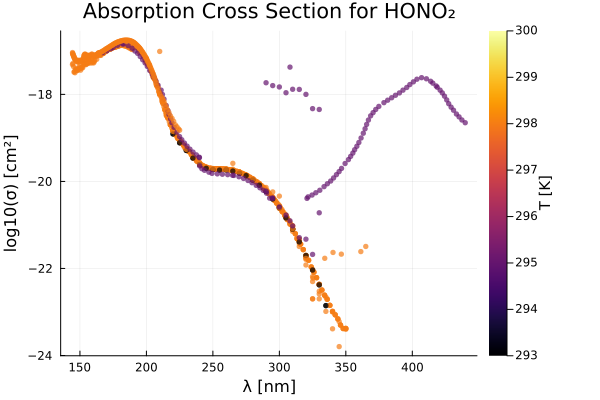

In [6]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

savefig("O3_p2.png")

display(p2)

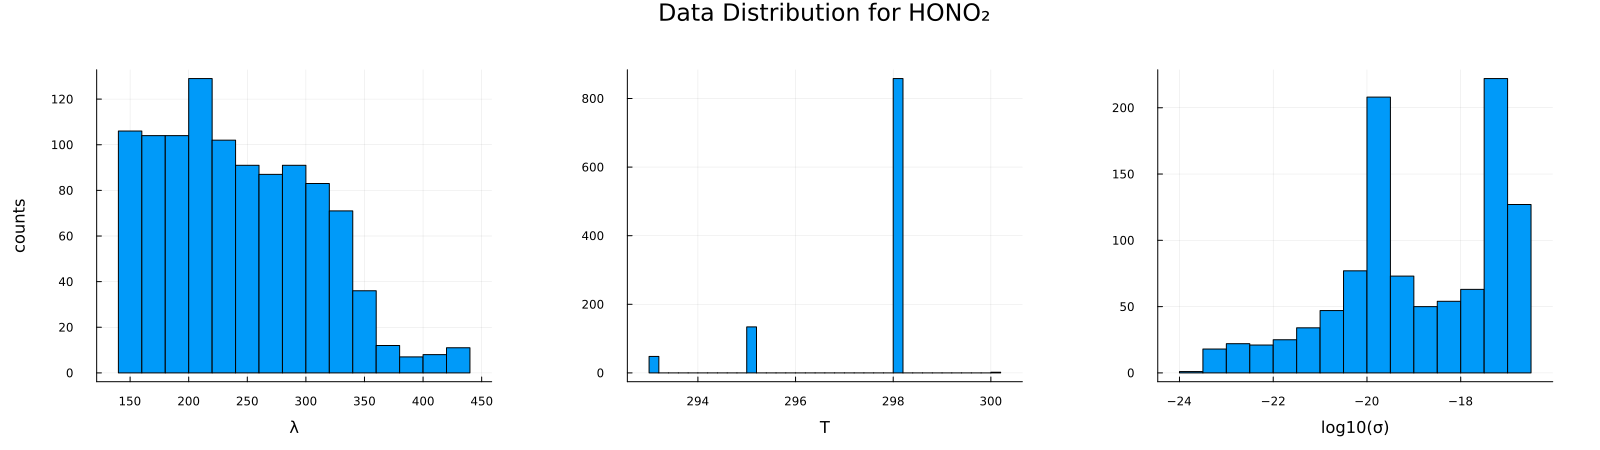

In [7]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="",)
p2 = histogram(df.T, xlabel="T", label="",)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="",)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450),  margin=10Plots.mm, plot_title="Data Distribution for $(nice_name)")

In [8]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

# Data Preprocessing

In [9]:
# deal with identical wavelength records 

gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

Row,λ,σ,T
,Float64,Float64,Float64
1,220.0,1.234e-19,293.0
2,225.0,7.73e-20,293.0
3,230.0,5.15e-20,293.0
4,235.0,3.44e-20,293.0
5,240.0,2.43e-20,293.0
6,245.0,2.0e-20,293.0
7,250.0,1.88e-20,293.0
8,255.0,1.82e-20,293.0
9,260.0,1.84e-20,293.0


In [10]:
# here is where we would do representative subsampling if there are too many records (> 2000) 
# λ_idxs = representative_rand_sample(df_unique.λ, 500, 1500)
# T_idxs = representative_rand_sample(df_unique.λ, 5, 1000)
# σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 

# idxs_res = shuffle(unique(vcat(λ_idxs, T_idxs, σ_idxs)))
# df_sampled = df_unique[idxs_res, :]

# filter out the weird low temperature data
df_sampled = df_unique[df_unique.T .≥ 297.0, :]

max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

println(nrow(df_sampled))
describe(df_sampled)

546


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,λ,211.7,144.36,199.17,365.01,0,Float64
2,σ,5.08335e-18,3.8e-24,4.355e-18,1.77e-17,0,Float64
3,T,298.007,298.0,298.0,300.0,0,Float64


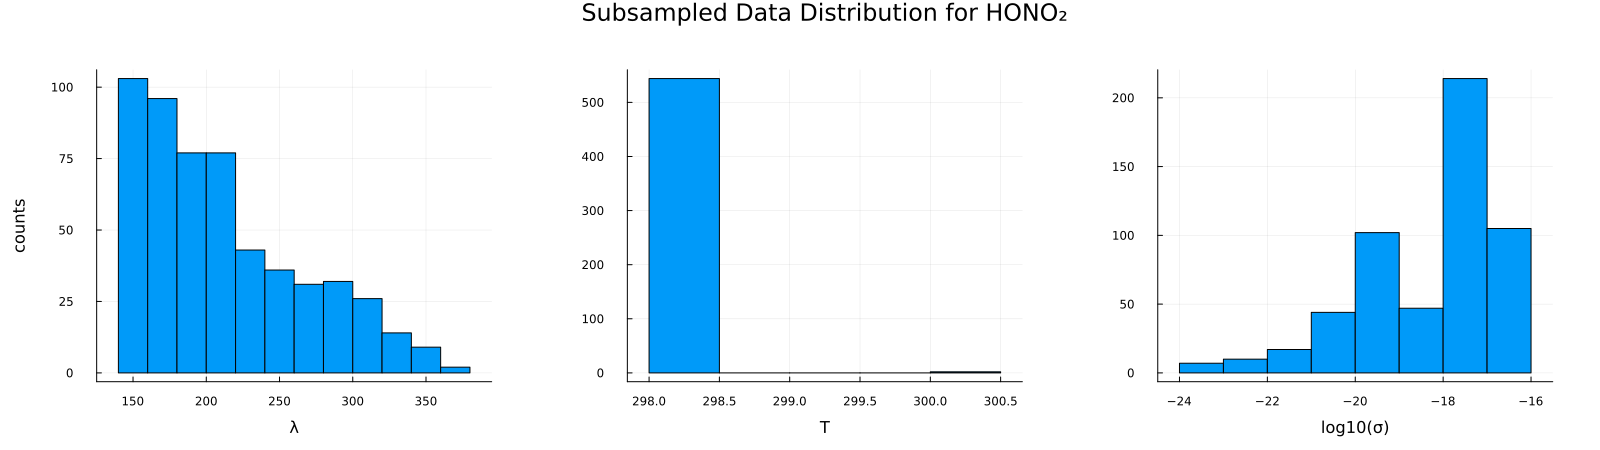

In [11]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

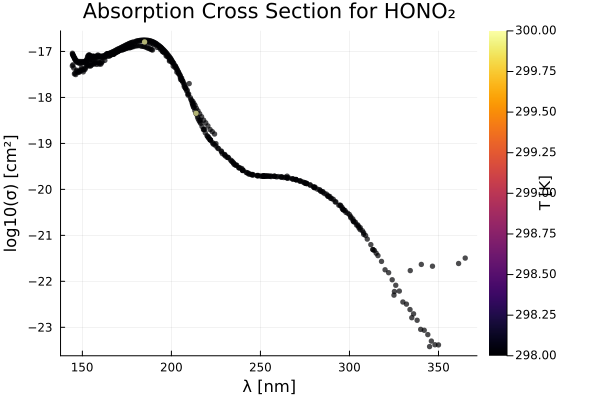

In [12]:
# visualize pre-processed data: 
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [13]:
train_frac = 0.95
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

518


In [14]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

28-element Vector{Float64}:
 -19.79317412396815
 -16.97881070093006
 -17.143271109617118
 -16.92701525537207
 -17.512861624522813
 -17.767003889607846
 -19.70996538863748
 -16.964570261815453
 -16.779891911959943
 -16.801342913045577
 -17.187086643357144
 -16.767003889607846
 -17.057595059143893
   ⋮
 -16.769551078621728
 -17.21896306137887
 -16.79317412396815
 -16.853871964321762
 -17.272458742971445
 -20.192464971931148
 -17.609064892896622
 -17.100726812682396
 -20.943095148663527
 -18.69897000433602
 -16.990549104201307
 -17.406713932979542

In [30]:
# compute length scales
κ = 0.5
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
SNR = 5 
σf² = var(ytrain)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))


function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [31]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(0.9462048807092881, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(4.69230344510097, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-1.7386933447960213, exp, 1.4901161193847656e-8)), 
  σ² = 0.10303660779892329, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [32]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0     2.722146e+02     3.291920e+02
 * time: 0.00016307830810546875
     1     8.045458e+01     2.188154e+02
 * time: 0.42438411712646484
     2    -2.593872e+02     8.381465e+01
 * time: 0.518369197845459
     3    -2.871966e+02     3.181836e+01
 * time: 0.5706090927124023
     4    -3.012697e+02     3.190376e+01
 * time: 0.6476500034332275
     5    -3.083750e+02     9.020309e+00
 * time: 0.7282991409301758
     6    -3.096597e+02     9.467922e+00
 * time: 0.805448055267334
     7    -3.124865e+02     8.728994e+00
 * time: 0.8826110363006592
     8    -3.127653e+02     2.890629e+00
 * time: 0.9419300556182861
     9    -3.127954e+02     1.515716e-01
 * time: 1.0159790515899658
    10    -3.127959e+02     2.687346e-02
 * time: 1.0971159934997559
    11    -3.127958e+02     3.039202e-03
 * time: 1.2011940479278564
    12    -3.127959e+02     4.718091e-03
 * time: 1.3015320301055908
    13    -3.127956e+02     4.174330e-03
 * time: 1.4227612

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @358 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @278 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [33]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [4.459849854570244, 3.603159209480028, -1.738819079271628, -4.279657677874657],
 minimum = -312.7956106646345,
 iterations = 37,
 converged = true,)

In [34]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/io9zQ/src/args.jl:1548


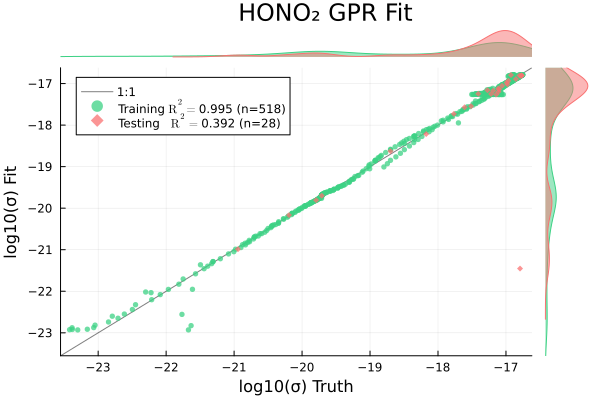

In [35]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)

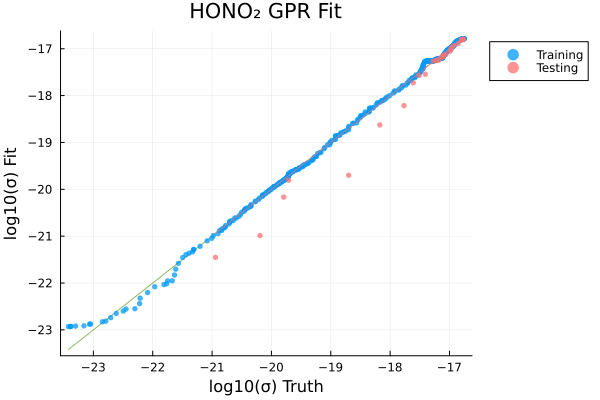

In [36]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


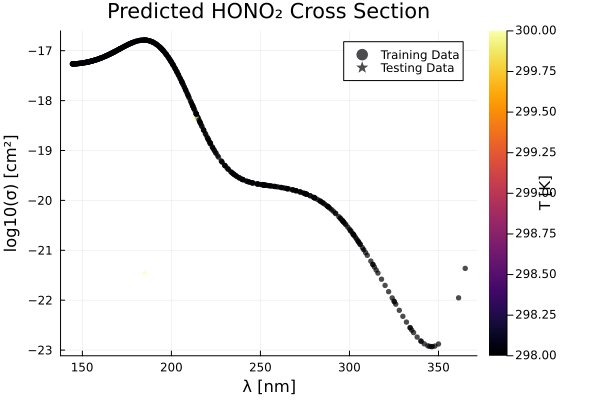

In [37]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)

194.249
365.01


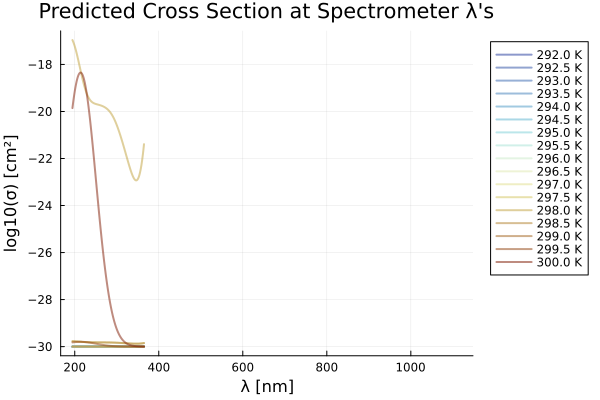

In [38]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

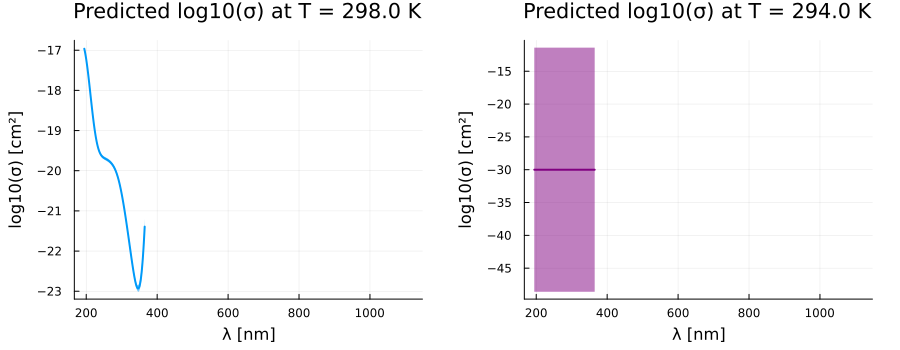

In [39]:
Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 294.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 

# Output for Photolysis Rate Determination

In [40]:
df_photolysis_σ = CSV.File("../photolysis_σ.csv") |> DataFrame 

describe(df_photolysis_σ)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,λ,667.499,194.249,672.636,1120.22,0,Float64
2,σ_1,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
3,σ_2,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
4,σ_3,2.15632e-20,0.0,0.0,7.82292e-19,0,Float64
5,σ_4,1.25113e-19,0.0,6.4171e-21,6.41009e-19,0,Float64
6,σ_5,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
7,σ_6,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
8,σ_7,8.4788e-20,0.0,0.0,2.33417e-18,0,Float64


In [41]:
λ_min = minimum(df_sampled.λ)
λ_max = maximum(df_sampled.λ)

println(λ_min, "\t", minimum(df_photolysis_σ.λ))
println(λ_max, "\t", maximum(df_photolysis_σ.λ))

144.36	194.249
365.01	1120.216


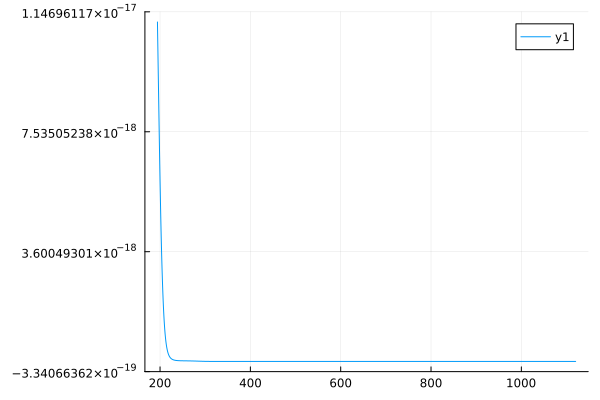

In [42]:
Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

σ = 10 .^ logσ

replace!(σ, NaN => 0.0)

# set anything outside of λ range to 0 as well
σ[hr4000_df.λ .< λ_min .|| hr4000_df.λ .> λ_max] .= 0.0


plot(hr4000_df.λ, σ)

In [43]:
df_photolysis_σ.σ_8 = σ

describe(df_photolysis_σ)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,λ,667.499,194.249,672.636,1120.22,0,Float64
2,σ_1,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
3,σ_2,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
4,σ_3,2.15632e-20,0.0,0.0,7.82292e-19,0,Float64
5,σ_4,1.25113e-19,0.0,6.4171e-21,6.41009e-19,0,Float64
6,σ_5,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
7,σ_6,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
8,σ_7,8.4788e-20,0.0,0.0,2.33417e-18,0,Float64
9,σ_8,8.92125e-20,0.0,0.0,1.11355e-17,0,Float64


In [44]:
CSV.write("../photolysis_σ.csv", df_photolysis_σ)

"../photolysis_σ.csv"